<a href="https://colab.research.google.com/github/YaokunLin/Models/blob/main/Classifier_Competition_on%C2%A0NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U scikit-learn

from sklearn.datasets import fetch_20newsgroups
X_train,y_train = fetch_20newsgroups(subset='train',# categories=categories,
                                shuffle=True, random_state=42,return_X_y=True
                                )

X_test, y_test = fetch_20newsgroups(subset='test', #categories=categories,
                               shuffle=True, random_state=42,return_X_y=True
                               )

     |████████████████████████████████| 22.3MB 1.5MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
len(X_train),len(X_test)

(11314, 7532)

In [3]:
X_train

["From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n",
 "From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 

In [4]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause
import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
import xgboost as xgb
from lightgbm import LGBMClassifier


# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

op = OptionParser()
op.add_option("--report",
              action="store_true", dest="print_report",
              help="Print a detailed classification report.")
op.add_option("--chi2_select",
              action="store", type="int", dest="select_chi2",
              help="Select some number of features using a chi-squared test")
op.add_option("--confusion_matrix",
              action="store_true", dest="print_cm",
              help="Print the confusion matrix.")
op.add_option("--top10",
              action="store_true", dest="print_top10",
              help="Print ten most discriminative terms per class"
                   " for every classifier.")
op.add_option("--all_categories",
              action="store_true", dest="all_categories",
              help="Whether to use all categories or not.")
op.add_option("--use_hashing",
              action="store_true",
              help="Use a hashing vectorizer.")
op.add_option("--n_features",
              action="store", type=int, default=2 ** 16,
              help="n_features when using the hashing vectorizer.")
op.add_option("--filtered",
              action="store_true",
              help="Remove newsgroup information that is easily overfit: "
                   "headers, signatures, and quoting.")


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

print(__doc__)
op.print_help()
print()

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --report              Print a detailed classification report.
  --chi2_select=SELECT_CHI2
                        Select some number of features using a chi-squared
                        test
  --confusion_matrix    Print the confusion matrix.
  --top10               Print ten most discriminative terms per class for
                        every classifier.
  --all_categories      Whether to use all categories or not.
  --use_hashing         Use a hashing vectorizer.
  --n_features=N_FEATURES
                        n_features when using the hashing vectorizer.
  --filtered            Remove newsgroup information that is easily overfit:
                        headers, signatures, and quoting.



In [5]:
opts.all_categories=True
opts.filtered=True

if opts.all_categories:
    categories = None
else:
    categories = [
        'alt.atheism',
        'talk.religion.misc',
        'comp.graphics',
        'sci.space',
    ]



if opts.filtered:
    remove = ('headers', 'footers', 'quotes')
else:
    remove = ()


print("Loading 20 newsgroups dataset for categories:")
print(categories if categories else "all")

data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)
print('data loaded')

# order of labels in `target_names` can be different from `categories`
target_names = data_train.target_names
print('categories:')
print(target_names)

def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6


data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print("%d documents - %0.3fMB (training set)" % (
    len(data_train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test.data), data_test_size_mb))
print("%d categories" % len(target_names))
print()

# split a training set and a test set
y_train, y_test = data_train.target, data_test.target

print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    vectorizer = HashingVectorizer(stop_words='english', alternate_sign=False,
                                   n_features=opts.n_features)
    X_train = vectorizer.transform(data_train.data)
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
    X_train = vectorizer.fit_transform(data_train.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

print("vectorizer used:")
print(vectorizer)

# mapping from integer feature name to original token string
if opts.use_hashing:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names()
print(feature_names)

if opts.select_chi2:
    print("Extracting %d best features by a chi-squared test" %
          opts.select_chi2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=opts.select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names:
        # keep selected feature names
        feature_names = [feature_names[i] for i
                         in ch2.get_support(indices=True)]
    print("done in %fs" % (time() - t0))
    print()

if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

Loading 20 newsgroups dataset for categories:
all
data loaded
categories:
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314 documents - 13.782MB (training set)
7532 documents - 8.262MB (test set)
20 categories

Extracting features from the training data using a sparse vectorizer
done in 1.966043s at 7.010MB/s
n_samples: 11314, n_features: 101322

Extracting features from the test data using the same vectorizer
done in 0.977578s at 8.451MB/s
n_samples: 7532, n_features: 101322

vectorizer used:
TfidfVectorizer(max_df=0.5, stop_words='english', sublinear_tf=True)
['00', '000', '0000', '00000', '000000', '00000000', '0000000004', '00000000b', '0

In [6]:
(vectorizer.get_feature_names()[::1000])

['00',
 '0h',
 '11100001',
 '16339',
 '1qi83b',
 '25x30',
 '2x4s',
 '3h',
 '491',
 '5685',
 '639',
 '6us',
 '7l4e',
 '8ffzu',
 '9a8',
 '_does',
 'a89',
 'adv21',
 'allotment',
 'apml',
 'assyria',
 'b3r',
 'beast',
 'bkdd',
 'breakdown',
 'c1i',
 'cated',
 'chipkeyk1',
 'cmcl2',
 'concurrence',
 'cots',
 'cursing',
 'dcc',
 'deselected',
 'disinformation',
 'drawed',
 'ebrandt',
 'emrick',
 'ethiopians',
 'f3fg',
 'ff1zv',
 'foolproof',
 'fwmr',
 'geode06',
 'gq30tb',
 'h378',
 'heaters',
 'holograph',
 'hzrcj',
 'imbecile',
 'innacurate',
 'irx',
 'jerseys',
 'jz75vzneut',
 'khojaly',
 'kxp2124',
 'legatus',
 'llat',
 'm13sm',
 'magnanamous',
 'mbes',
 'meteosat',
 'mitcc7_b_',
 'morpl',
 'musil',
 'nbc',
 'nko',
 'o5hp1en',
 'ooops',
 'ovk9lg',
 'patl7a',
 'phono',
 'poley',
 'princess',
 'purporting',
 'quandaries',
 'razmella',
 'relations',
 'rfi',
 'rotate',
 'sadist',
 'scx_sy',
 'shickley',
 'slaughter',
 'spearhead',
 'stavropol',
 'suggestionas',
 't3dlib',
 'tenour',
 'tl1mm

In [7]:
len(vectorizer.get_feature_names())

101322

In [56]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time



results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        #(LGBMClassifier(),'lgbm'),
        #(xgb.XGBClassifier(objective="multi:softprob", random_state=42,verbose=10),"xgb"),
        (MLPClassifier(random_state=1, max_iter=300,early_stopping=True,hidden_layer_sizes=(200,100)),"MLP"),
        (LogisticRegression(random_state=0,n_jobs=-1),"Logistic"),
        (PassiveAggressiveClassifier(max_iter=50),"Passive-Aggressive"),
        
        #(GradientBoostingClassifier(),'GBM'),
        (KNeighborsClassifier(n_neighbors=5), "kNN"),
        (RandomForestClassifier(), "Random forest")):
        

    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

# light GBM
print('=' * 80)
print("lgbm")

results.append(
    benchmark(LGBMClassifier()))


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sag', tol=0.01)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:556: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


train time: 5.708s
test time:  0.025s
accuracy:   0.704
dimensionality: 101322
density: 1.000000


Perceptron
________________________________________________________________________________
Training: 
Perceptron(max_iter=50)
train time: 0.978s
test time:  0.035s
accuracy:   0.634
dimensionality: 101322
density: 0.118555


MLP
________________________________________________________________________________
Training: 
MLPClassifier(early_stopping=True, hidden_layer_sizes=(200, 100), max_iter=300,
              random_state=1)
train time: 569.403s
test time:  0.230s
accuracy:   0.696

Logistic
________________________________________________________________________________
Training: 
LogisticRegression(n_jobs=-1, random_state=0)
train time: 32.540s
test time:  0.024s
accuracy:   0.695
dimensionality: 101322
density: 1.000000


Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(max_iter=50)
train time:

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


test time:  0.110s
accuracy:   0.567
dimensionality: 101322
density: 1.000000


________________________________________________________________________________
Training: 
ComplementNB(alpha=0.1)
train time: 0.133s
test time:  0.025s
accuracy:   0.708
dimensionality: 101322
density: 1.000000


LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1',
                                                     tol=0.001))),
                ('classification', LinearSVC())])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


train time: 5.260s
test time:  0.023s
accuracy:   0.681

lgbm
________________________________________________________________________________
Training: 
LGBMClassifier()
train time: 444.373s
test time:  7.848s
accuracy:   0.610



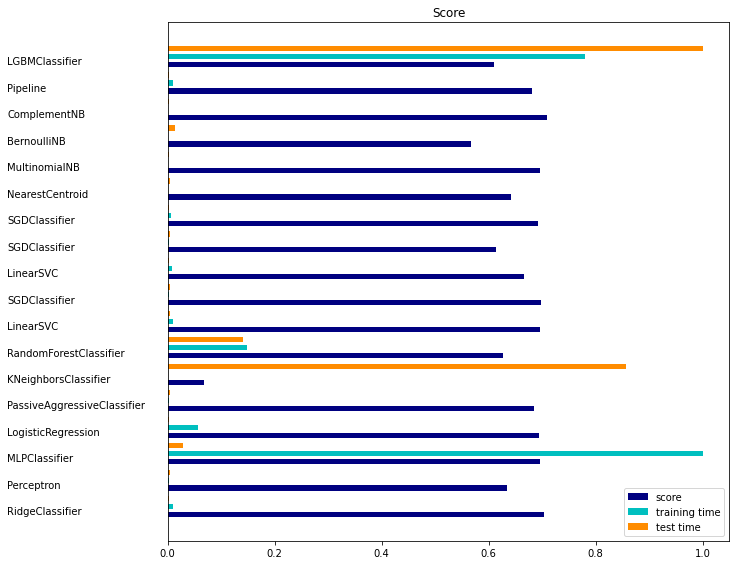

In [62]:

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results

indices = np.arange(len(score))
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()